In [1]:
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import glob
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import pydot
import graphviz
# import pydotplus
import warnings
import itertools

In [2]:
from functools import partial
from itertools import product
from sklearn.model_selection import ParameterGrid

In [3]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

In [4]:
#%%Seed 설정 (중요)
tf.random.set_seed(2022)
np.random.seed(2022)

### dir

In [5]:
root_dir = 'C:/Users/begas/'

## 데이터 불러오기

In [6]:
from pandas_datareader import data as pdr
import seaborn as sns

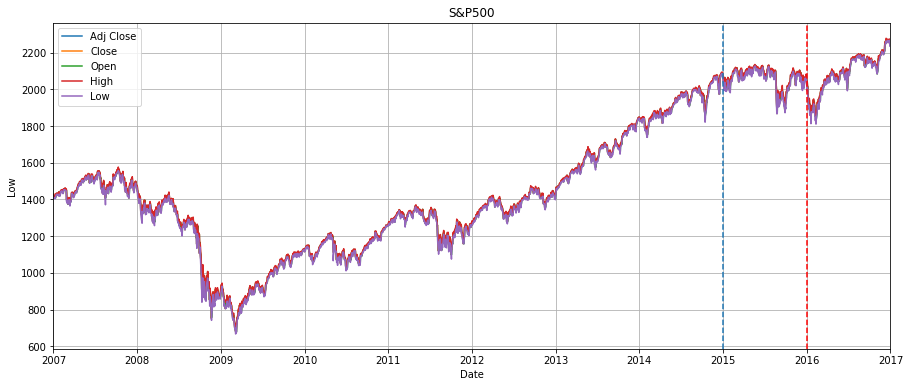

In [7]:
# ===========================================================
# Market Data
# ===========================================================
raw_data = pdr.DataReader('^GSPC', data_source='yahoo', start='2006-10-01', end='2017-01-10')
raw_data.sort_index(inplace=True)

# Train / Valid / Test 기간 그림 그리기
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=raw_data, x=raw_data.index, y='Adj Close', ax=ax, label = 'Adj Close')
sns.lineplot(data=raw_data, x=raw_data.index, y='Close', ax=ax, label = 'Close')
sns.lineplot(data=raw_data, x=raw_data.index, y='Open', ax=ax, label = 'Open')
sns.lineplot(data=raw_data, x=raw_data.index, y='High', ax=ax, label = 'High')
sns.lineplot(data=raw_data, x=raw_data.index, y='Low', ax=ax, label = 'Low')

ax.grid()
ax.set_title("S&P500")
ax.set_xlim(pd.to_datetime('2007-01-01'),pd.to_datetime('2017-01-01'))
ax.axvline(pd.to_datetime('2015-01-01'),linestyle = '--')
ax.axvline(pd.to_datetime('2016-01-01'),linestyle = '--', color = 'red')
plt.show()

ana_data = raw_data.copy()

# ana_data['d_05'] = ana_data['Adj Close'].rolling(5).mean()
# ana_data['d_10'] = ana_data['Adj Close'].rolling(10).mean()
# ana_data['d_15'] = ana_data['Adj Close'].rolling(15).mean()
# ana_data['d_20'] = ana_data['Adj Close'].rolling(20).mean()
# ana_data['d_25'] = ana_data['Adj Close'].rolling(25).mean()
# ana_data['d_30'] = ana_data['Adj Close'].rolling(30).mean()
ana_data['y'] = ana_data['Adj Close'].shift(-1)
# ana_data['y'] = ana_data['Adj Close'].pct_change(1).shift(-1)
ana_data['BAS_DT'] = ana_data.index
ana_data['PRED_DT'] = ana_data['BAS_DT'].shift(-1)

ana_data = ana_data.dropna()

### 데이터 전처리

In [8]:
class preprocess():
    
    def __init__(self, window_size, interval, data) :
        self.window_size = window_size
        self.interval = interval
        self.data     = data
        self._preprocess()
        
    def _preprocess(self):
        self.dim_batch = len(self.data) - self.interval*(self.window_size-1)
        self.idx_array = [np.arange(s, self.window_size * self.interval + s, step = self.interval) for s in range(self.dim_batch)]
        self.slice_df = [self.data.iloc[s] for s in self.idx_array]
        
        y_cols = ['y']
        date_cols = ['BAS_DT','PRED_DT']
        
        # window size, interval에 따라 데이터 slice
        self.slice_x_array = np.array([np.array(self.slice_df[s].loc[:,~self.slice_df[s].columns.isin(y_cols + date_cols)]) for s in range(len(self.slice_df))])
        self.slice_y_array = np.array([np.array(self.slice_df[s].loc[:,self.slice_df[s].columns.isin(y_cols)]) for s in range(len(self.slice_df))])
        self.slice_date_df = pd.concat([self.slice_df[s].loc[:,self.slice_df[s].columns.isin(date_cols)].tail(1) for s in range(len(self.slice_df))])
        
        # Train, Valid, Test 날짜 지정
        Train_Start_DT = pd.to_datetime('2007-01-01')
        Train_End_DT = pd.to_datetime('2014-12-31')

        Valid_Start_DT = pd.to_datetime('2015-01-01')
        Valid_End_DT = pd.to_datetime('2015-12-31')

        Test_Start_DT = pd.to_datetime('2016-01-01')
        Test_End_DT = pd.to_datetime('2016-12-31')
        
        # Train, Valid, Test 데이터 인덱스 생성
        self.Train_Idx = ((Train_Start_DT <= self.slice_date_df['PRED_DT']) & (self.slice_date_df['PRED_DT'] <= Train_End_DT))
        self.Valid_Idx = ((Valid_Start_DT <= self.slice_date_df['PRED_DT']) & (self.slice_date_df['PRED_DT'] <= Valid_End_DT))
        self.Test_Idx = ((Test_Start_DT <= self.slice_date_df['PRED_DT']) & (self.slice_date_df['PRED_DT'] <= Test_End_DT))
           
        # Train, Valid, Test 데이터 추출
        self.Train_x = self.slice_x_array[self.Train_Idx,:,:]
        self.Train_y = self.slice_y_array[self.Train_Idx,:,:]

        self.Valid_x = self.slice_x_array[self.Valid_Idx,:,:]
        self.Valid_y = self.slice_y_array[self.Valid_Idx,:,:]

        self.Test_x = self.slice_x_array[self.Test_Idx,:,:]
        self.Test_y = self.slice_y_array[self.Test_Idx,:,:]
        
        # Calculate Min, Max
        self.train_x_min = np.apply_along_axis(min, 0, self.Train_x.reshape(-1,self.Train_x.shape[2]))
        self.train_x_max = np.apply_along_axis(max, 0, self.Train_x.reshape(-1,self.Train_x.shape[2]))
        
        # Min, Max Scaling
        self.Train_x = np.apply_along_axis(lambda xx : (xx - self.train_x_min)/(self.train_x_max - self.train_x_min), 2, self.Train_x)
        self.Valid_x = np.apply_along_axis(lambda xx : (xx - self.train_x_min)/(self.train_x_max - self.train_x_min), 2, self.Valid_x)
        self.Test_x = np.apply_along_axis(lambda xx : (xx - self.train_x_min)/(self.train_x_max - self.train_x_min), 2, self.Test_x)

# [Preprocess] Data For Train

In [9]:
params_grid = {
    "window_size" : [10],
    "interval"    : [1],
    "nKernelSize"    : [3],
    "nFilters"    : [16,32],
    "nUnits"      : [16,32,64],
    "nLearningRate" : [0.1],
    "nBatchSize"  : [16]
}

params_grid_df = pd.DataFrame(ParameterGrid(params_grid))

### Data Preprocess

In [10]:
data_dict = {"window_size" : [],
             "interval"    : [],
             "result"      : []}   

In [11]:
for params_idx, params in params_grid_df[['window_size','interval']].drop_duplicates().iterrows() :
    print(f'[params_idx : {params_idx}] / [window_size : {params["window_size"]}] / [interval : {params["interval"]}]')
    preprocess_result = preprocess(int(params['window_size']),int(params['interval']),ana_data)
    data_dict['window_size'].append(params["window_size"])
    data_dict['interval'].append(params["interval"])
    data_dict['result'].append(preprocess_result)
    del(preprocess_result)

[params_idx : 0] / [window_size : 10] / [interval : 1]


# [Model 1] Base Gru Model

### Base GRU Model 생성

In [12]:
class base_gru_model():
    
    def __init__(self, nTimeSteps, nFeatures, nUnits, nLearningRate) :
        self.nTimeSteps = nTimeSteps
        self.nFeatures = nFeatures
        self.nUnits = nUnits
        self.nLearningRate = nLearningRate
        self._build()
        self._compile()
        
    def _build(self):
        self.input_layer = tf.keras.Input(shape=(self.nTimeSteps, self.nFeatures))
        self.gru_layer = tf.keras.layers.GRU(self.nUnits,return_sequences=True)(self.input_layer)
        self.output_layer = tf.keras.layers.Dense(1,activation = 'linear',
                                                  kernel_initializer = tf.keras.initializers.orthogonal(seed = 1234))( self.gru_layer)
        self.base_model = tf.keras.Model(inputs =  self.input_layer, outputs =  self.output_layer)

        
    # # custom loss
    # def custom_loss(y_true, y_pred):
    #     true_mean = tf.reduce_mean(y_true)
    #     pred_mean = tf.reduce_mean(y_pred)
    #     rmse = tf.sqrt(tf.reduce_mean((y_true - y_pred)**2)) 
    #     corr = (tf.reduce_mean(y_true * y_pred) - true_mean*pred_mean)/(tf.math.reduce_std(y_true)*tf.math.reduce_std(y_pred))
    #     return rmse + 1/abs(corr) + abs(true_mean-pred_mean)

    # custom mse loss
    # def custom_mse_loss(y_true, y_pred):
    #     mse = tf.reduce_mean((y_true - y_pred)**2)
    #     return mse    
    
    def _compile(self):
        self.optim = tf.keras.optimizers.RMSprop(learning_rate =  self.nLearningRate)
        self.base_model.compile(optimizer = self.optim, loss = 'mse')

### Model Build

In [13]:
base_model_list = []
for params_idx, params in params_grid_df[['interval','nBatchSize','nLearningRate','nUnits','window_size']].drop_duplicates().iterrows() :
    print(f'[params_idx : {params_idx}] Build Complete')
    preprocess_idx = np.argwhere([(s == params["window_size"])*(k == params["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]
    
    nTimeSteps = int(data_dict['window_size'][preprocess_idx])
    nFeatures  = int(data_dict['result'][preprocess_idx].Test_x.shape[2])
    
    base_model_list.append(base_gru_model(nTimeSteps,nFeatures,int(params['nUnits']),params['nLearningRate']))

[params_idx : 0] Build Complete
[params_idx : 1] Build Complete
[params_idx : 2] Build Complete


### Model Fitting

In [14]:
# fitting
for params_idx, params in params_grid_df[['interval','nBatchSize','nLearningRate','nUnits','window_size']].drop_duplicates().iterrows() :
    print('-' * 50)
    print(f'[params_idx : {params_idx}] Fit Start')
    preprocess_idx = np.argwhere([(s == params["window_size"])*(k == params["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]
    
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=20, restore_best_weights=True)
    ReduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss' , mode = 'min', factor=0.5, patience= 5 , min_lr = params["nLearningRate"]*(0.5**4))
    
    base_model_list[params_idx].base_model.fit(x = data_dict['result'][preprocess_idx].Train_x, 
                                               y = data_dict['result'][preprocess_idx].Train_y, 
                                               validation_data=(data_dict['result'][preprocess_idx].Valid_x, data_dict['result'][preprocess_idx].Valid_y), 
                                               batch_size = int(params['nBatchSize']),
                                               callbacks=[EarlyStopping,ReduceLr], epochs=200, shuffle = True)
    
    print(f'[params_idx : {params_idx}] Fit End')
    print('-' * 50)

--------------------------------------------------
[params_idx : 0] Fit Start
Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
115/126 [==========================>...] - ETA: 0s - loss: 1694128.0000WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E053FBB318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, 

126/126 [==============================] - 1s 5ms/step - loss: 951.3530 - val_loss: 2349.6714 - lr: 0.0063
Epoch 53/200
126/126 [==============================] - 1s 6ms/step - loss: 953.7314 - val_loss: 2348.8127 - lr: 0.0063
Epoch 54/200
126/126 [==============================] - 1s 4ms/step - loss: 951.5109 - val_loss: 2458.1140 - lr: 0.0063
Epoch 55/200
126/126 [==============================] - 1s 4ms/step - loss: 953.4297 - val_loss: 2392.2302 - lr: 0.0063
Epoch 56/200
126/126 [==============================] - 1s 4ms/step - loss: 952.1160 - val_loss: 2526.8403 - lr: 0.0063
Epoch 57/200
126/126 [==============================] - 1s 4ms/step - loss: 951.2483 - val_loss: 2345.5706 - lr: 0.0063
Epoch 58/200
126/126 [==============================] - 1s 4ms/step - loss: 949.8391 - val_loss: 2324.3611 - lr: 0.0063
Epoch 59/200
126/126 [==============================] - 1s 5ms/step - loss: 950.0208 - val_loss: 2408.2007 - lr: 0.0063
Epoch 60/200
126/126 [==============================]

Epoch 39/200
126/126 [==============================] - 1s 5ms/step - loss: 399.9309 - val_loss: 1085.4567 - lr: 0.0500
Epoch 40/200
126/126 [==============================] - 1s 5ms/step - loss: 400.6632 - val_loss: 1175.7682 - lr: 0.0500
Epoch 41/200
126/126 [==============================] - 1s 5ms/step - loss: 413.5112 - val_loss: 1113.0702 - lr: 0.0500
Epoch 42/200
126/126 [==============================] - 1s 5ms/step - loss: 393.1594 - val_loss: 1207.7035 - lr: 0.0500
Epoch 43/200
126/126 [==============================] - 1s 5ms/step - loss: 414.9836 - val_loss: 1050.1656 - lr: 0.0500
Epoch 44/200
126/126 [==============================] - 1s 5ms/step - loss: 399.7163 - val_loss: 974.9653 - lr: 0.0500
Epoch 45/200
126/126 [==============================] - 1s 6ms/step - loss: 396.6930 - val_loss: 1964.7147 - lr: 0.0500
Epoch 46/200
126/126 [==============================] - 1s 6ms/step - loss: 402.1187 - val_loss: 3161.0305 - lr: 0.0500
Epoch 47/200
126/126 [===================

126/126 [==============================] - 1s 5ms/step - loss: 1247.0895 - val_loss: 4815.1567 - lr: 0.1000
Epoch 13/200
126/126 [==============================] - 1s 5ms/step - loss: 1136.9139 - val_loss: 5834.0117 - lr: 0.1000
Epoch 14/200
126/126 [==============================] - 1s 5ms/step - loss: 1095.0701 - val_loss: 10392.4932 - lr: 0.1000
Epoch 15/200
126/126 [==============================] - 1s 5ms/step - loss: 1055.8213 - val_loss: 3544.0691 - lr: 0.1000
Epoch 16/200
126/126 [==============================] - 1s 5ms/step - loss: 944.5399 - val_loss: 4831.6240 - lr: 0.1000
Epoch 17/200
126/126 [==============================] - 1s 5ms/step - loss: 925.1442 - val_loss: 2522.9109 - lr: 0.1000
Epoch 18/200
126/126 [==============================] - 1s 5ms/step - loss: 925.0801 - val_loss: 4002.9541 - lr: 0.1000
Epoch 19/200
126/126 [==============================] - 1s 5ms/step - loss: 957.7434 - val_loss: 2953.3057 - lr: 0.1000
Epoch 20/200
126/126 [==========================

126/126 [==============================] - 1s 12ms/step - loss: 265.5222 - val_loss: 693.6826 - lr: 0.0063
Epoch 81/200
126/126 [==============================] - 1s 10ms/step - loss: 266.5581 - val_loss: 706.2678 - lr: 0.0063
Epoch 82/200
126/126 [==============================] - 1s 10ms/step - loss: 265.9107 - val_loss: 665.1642 - lr: 0.0063
Epoch 83/200
126/126 [==============================] - 1s 7ms/step - loss: 265.6984 - val_loss: 641.6600 - lr: 0.0063
Epoch 84/200
126/126 [==============================] - 1s 6ms/step - loss: 269.2869 - val_loss: 658.2058 - lr: 0.0063
Epoch 85/200
126/126 [==============================] - 1s 8ms/step - loss: 265.3478 - val_loss: 732.0538 - lr: 0.0063
Epoch 86/200
126/126 [==============================] - 1s 8ms/step - loss: 265.6267 - val_loss: 736.0579 - lr: 0.0063
Epoch 87/200
126/126 [==============================] - 1s 6ms/step - loss: 264.4805 - val_loss: 641.9697 - lr: 0.0063
Epoch 88/200
126/126 [==============================] - 1s

126/126 [==============================] - 1s 5ms/step - loss: 257.0034 - val_loss: 546.8852 - lr: 0.0063
Epoch 149/200
126/126 [==============================] - 1s 5ms/step - loss: 257.6429 - val_loss: 587.2097 - lr: 0.0063
Epoch 150/200
126/126 [==============================] - 1s 5ms/step - loss: 256.5640 - val_loss: 577.7035 - lr: 0.0063
Epoch 151/200
126/126 [==============================] - 1s 5ms/step - loss: 258.7522 - val_loss: 543.9706 - lr: 0.0063
Epoch 152/200
126/126 [==============================] - 1s 5ms/step - loss: 258.1607 - val_loss: 641.4474 - lr: 0.0063
Epoch 153/200
126/126 [==============================] - 1s 5ms/step - loss: 256.8928 - val_loss: 560.5920 - lr: 0.0063
Epoch 154/200
126/126 [==============================] - 1s 6ms/step - loss: 257.6520 - val_loss: 1394.3561 - lr: 0.0063
Epoch 155/200
126/126 [==============================] - 1s 7ms/step - loss: 257.4907 - val_loss: 542.9503 - lr: 0.0063
Epoch 156/200
126/126 [==============================

### Find Best Model

In [15]:
# rmse
rmse_list = []
for params_idx, params in params_grid_df[['interval','nBatchSize','nLearningRate','nUnits','window_size']].drop_duplicates().iterrows() :
    print('-' * 50)
    preprocess_idx = np.argwhere([(s == params["window_size"])*(k == params["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]
    
    valid_pred = base_model_list[params_idx].base_model.predict(data_dict['result'][preprocess_idx].Valid_x)
    rmse = tf.reduce_mean((data_dict['result'][preprocess_idx].Valid_y[:,-1,:] - valid_pred[:,-1,:])**2)
    rmse_list.append(rmse)

--------------------------------------------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 0s 2ms/step
--------------------------------------------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

In [16]:
# best Model idx
best_model_idx = np.argmin(np.array(rmse_list))

# Best Model Preprcess Idx
preprocess_idx = np.argwhere([(s == params_grid_df.iloc[best_model_idx]["window_size"])*
                              (k == params_grid_df.iloc[best_model_idx]["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]

In [17]:
train_pred = base_model_list[best_model_idx].base_model.predict(data_dict['result'][preprocess_idx].Train_x)
valid_pred = base_model_list[best_model_idx].base_model.predict(data_dict['result'][preprocess_idx].Valid_x)
test_pred = base_model_list[best_model_idx].base_model.predict(data_dict['result'][preprocess_idx].Test_x)

8/8 [==============================] - 0s 2ms/step


### Graph

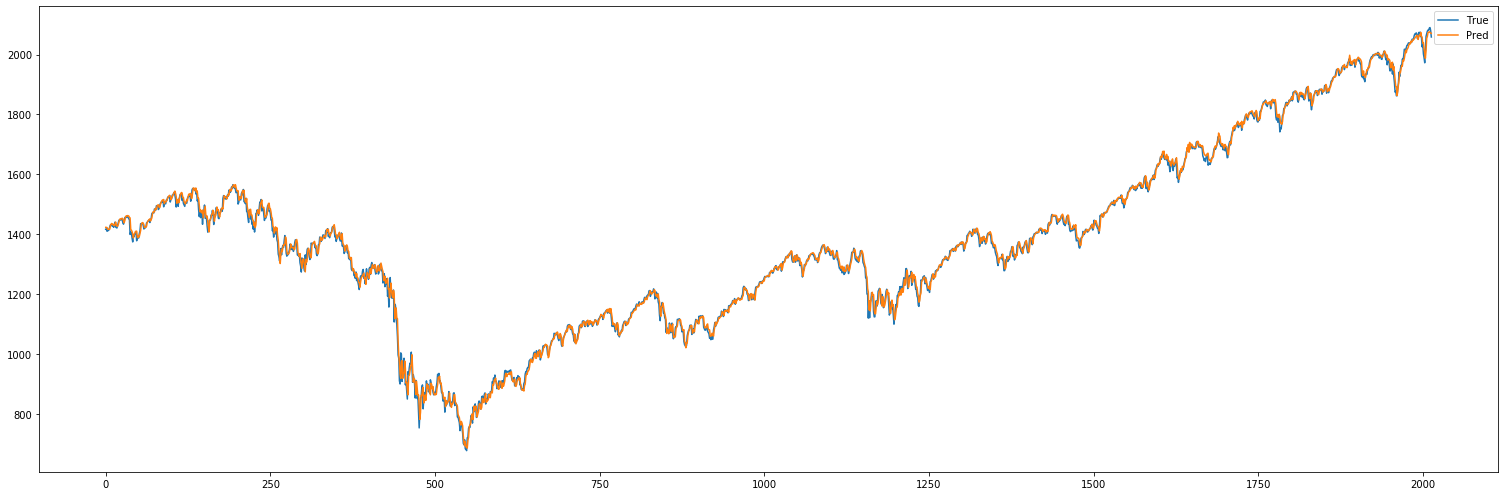

In [18]:
fig, ax = plt.subplots(1,1,figsize = (21,7))
ax.plot(data_dict['result'][preprocess_idx].Train_y[:,-1,:], label = 'True')
ax.plot(train_pred[:,-1,:], label = 'Pred')
ax.legend()
fig.tight_layout()

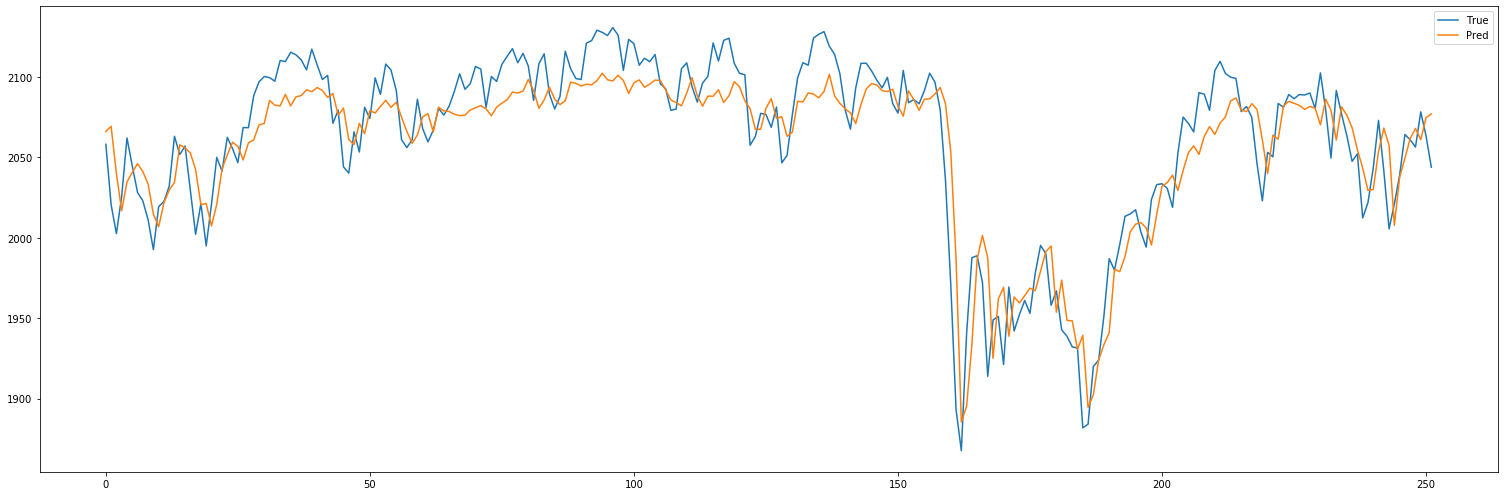

In [19]:
fig, ax = plt.subplots(1,1,figsize = (21,7))
ax.plot(data_dict['result'][preprocess_idx].Valid_y[:,-1,:], label = 'True')
ax.plot(valid_pred[:,-1,:], label = 'Pred')
ax.legend()
fig.tight_layout()

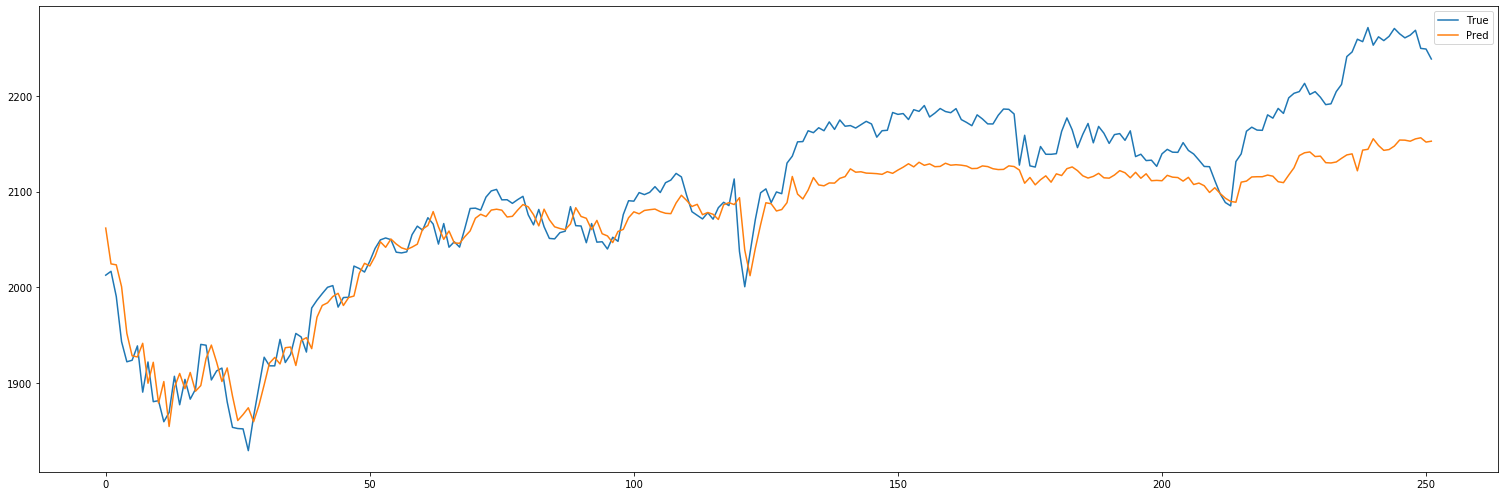

In [20]:
fig, ax = plt.subplots(1,1,figsize = (21,7))
ax.plot(data_dict['result'][preprocess_idx].Test_y[:,-1,:], label = 'True')
ax.plot(test_pred[:,-1,:], label = 'Pred')
ax.legend()
fig.tight_layout()

# [Model 2] Cnn Gru Model

### CNN GRU Model

In [21]:
class base_gru_model():
    
    def __init__(self, nTimeSteps, nFeatures,nKernelSize, nFilters, nUnits, nLearningRate) :
        self.nTimeSteps = nTimeSteps
        self.nFeatures = nFeatures
        self.nKernelSize = nKernelSize
        self.nFilters = nFilters
        self.nUnits = nUnits
        self.nLearningRate = nLearningRate
        self._build()
        self._compile()
        
    def _build(self):
        self.input_layer = tf.keras.Input(shape=(self.nTimeSteps, self.nFeatures))
        self.cnn_layer = tf.keras.layers.Conv1D(filters = self.nFilters, kernel_size = self.nKernelSize, strides = 1, padding = 'same')(self.input_layer)
#         self.cnn_layer = tf.keras.layers.BatchNormalization()(self.cnn_layer)
        self.cnn_layer = tf.keras.layers.Activation(activation = 'relu')(self.cnn_layer)
        self.gru_layer = tf.keras.layers.GRU(self.nUnits,return_sequences=True)(self.cnn_layer)
        self.output_layer = tf.keras.layers.Dense(1,activation = 'linear',
                                                          kernel_initializer = tf.keras.initializers.orthogonal(seed = 1234))(self.gru_layer)
        self.cnn_gru_model = tf.keras.Model(inputs =  self.input_layer, outputs = self.output_layer)

        
    # # custom loss
    # def custom_loss(y_true, y_pred):
    #     true_mean = tf.reduce_mean(y_true)
    #     pred_mean = tf.reduce_mean(y_pred)
    #     rmse = tf.sqrt(tf.reduce_mean((y_true - y_pred)**2)) 
    #     corr = (tf.reduce_mean(y_true * y_pred) - true_mean*pred_mean)/(tf.math.reduce_std(y_true)*tf.math.reduce_std(y_pred))
    #     return rmse + 1/abs(corr) + abs(true_mean-pred_mean)

    # custom mse loss
    # def custom_mse_loss(y_true, y_pred):
    #     mse = tf.reduce_mean((y_true - y_pred)**2)
    #     return mse    
    
    def _compile(self):
        self.optim = tf.keras.optimizers.RMSprop(learning_rate =  self.nLearningRate)
        self.cnn_gru_model.compile(optimizer = self.optim, loss = 'mse')

### Model Build

In [22]:
cnn_gru_model_list = []
for params_idx, params in params_grid_df.iterrows() :
    print(f'[params_idx : {params_idx}] Build Complete')
    preprocess_idx = np.argwhere([(s == params["window_size"])*(k == params["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]
    
    nTimeSteps = int(data_dict['window_size'][preprocess_idx])
    nFeatures  = int(data_dict['result'][preprocess_idx].Test_x.shape[2])
    
    cnn_gru_model_list.append(base_gru_model(nTimeSteps,nFeatures,int(params['nKernelSize']),int(params['nFilters']),int(params['nUnits']),params['nLearningRate']))

[params_idx : 0] Build Complete
[params_idx : 1] Build Complete
[params_idx : 2] Build Complete
[params_idx : 3] Build Complete
[params_idx : 4] Build Complete
[params_idx : 5] Build Complete


### Model Fitting

In [23]:
# fitting
for params_idx, params in params_grid_df.iterrows() :
    print('-' * 50)
    print(f'[params_idx : {params_idx}] Fit Start')
    preprocess_idx = np.argwhere([(s == params["window_size"])*(k == params["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]
    
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=20, restore_best_weights=True)
    ReduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss' , mode = 'min', factor=0.5, patience= 5 , min_lr = params["nLearningRate"]*(0.5**4))
    
    cnn_gru_model_list[params_idx].cnn_gru_model.fit(x = data_dict['result'][preprocess_idx].Train_x, 
                                                     y = data_dict['result'][preprocess_idx].Train_y, 
                                                     validation_data=(data_dict['result'][preprocess_idx].Valid_x, data_dict['result'][preprocess_idx].Valid_y), 
                                                     batch_size = int(params['nBatchSize']),
                                                     callbacks=[EarlyStopping,ReduceLr], epochs=200, shuffle = True)
    
    print(f'[params_idx : {params_idx}] Fit End')
    print('-' * 50)

--------------------------------------------------
[params_idx : 0] Fit Start
Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
123/126 [============================>.] - ETA: 0s - loss: 1707274.3750WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E063E61E58> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, 

Epoch 52/200
126/126 [==============================] - 1s 5ms/step - loss: 1045.6896 - val_loss: 5013.1689 - lr: 0.0125
Epoch 53/200
126/126 [==============================] - 1s 5ms/step - loss: 639.4831 - val_loss: 4996.5952 - lr: 0.0125
Epoch 54/200
126/126 [==============================] - 1s 5ms/step - loss: 452.7988 - val_loss: 4770.7778 - lr: 0.0125
Epoch 55/200
126/126 [==============================] - 1s 5ms/step - loss: 414.7737 - val_loss: 4534.9883 - lr: 0.0125
Epoch 56/200
126/126 [==============================] - 1s 5ms/step - loss: 388.7301 - val_loss: 4354.1201 - lr: 0.0125
Epoch 57/200
126/126 [==============================] - 1s 5ms/step - loss: 370.4712 - val_loss: 4143.4019 - lr: 0.0125
Epoch 58/200
126/126 [==============================] - 1s 5ms/step - loss: 353.1537 - val_loss: 4165.0674 - lr: 0.0125
Epoch 59/200
126/126 [==============================] - 1s 5ms/step - loss: 341.8943 - val_loss: 3953.6504 - lr: 0.0125
Epoch 60/200
126/126 [=================

126/126 [==============================] - 1s 5ms/step - loss: 108.4151 - val_loss: 903.8760 - lr: 0.0063
Epoch 121/200
126/126 [==============================] - 1s 6ms/step - loss: 114.4283 - val_loss: 1119.2543 - lr: 0.0063
Epoch 122/200
126/126 [==============================] - 1s 6ms/step - loss: 199.0341 - val_loss: 1180.3229 - lr: 0.0063
Epoch 123/200
126/126 [==============================] - 1s 5ms/step - loss: 107.6580 - val_loss: 857.2930 - lr: 0.0063
Epoch 124/200
126/126 [==============================] - 1s 5ms/step - loss: 109.4151 - val_loss: 813.6772 - lr: 0.0063
Epoch 125/200
126/126 [==============================] - 1s 6ms/step - loss: 106.1847 - val_loss: 1235.3936 - lr: 0.0063
Epoch 126/200
126/126 [==============================] - 1s 6ms/step - loss: 139.9494 - val_loss: 647.3755 - lr: 0.0063
Epoch 127/200
126/126 [==============================] - 1s 5ms/step - loss: 103.2163 - val_loss: 627.3474 - lr: 0.0063
Epoch 128/200
126/126 [============================

Epoch 189/200
126/126 [==============================] - 1s 6ms/step - loss: 81.8102 - val_loss: 852.6112 - lr: 0.0063
Epoch 190/200
126/126 [==============================] - 1s 6ms/step - loss: 83.2426 - val_loss: 395.4411 - lr: 0.0063
Epoch 191/200
126/126 [==============================] - 1s 6ms/step - loss: 81.3525 - val_loss: 443.3174 - lr: 0.0063
Epoch 192/200
126/126 [==============================] - 1s 6ms/step - loss: 82.6265 - val_loss: 414.5891 - lr: 0.0063
Epoch 193/200
126/126 [==============================] - 1s 6ms/step - loss: 82.6884 - val_loss: 444.2744 - lr: 0.0063
Epoch 194/200
126/126 [==============================] - 1s 8ms/step - loss: 79.6693 - val_loss: 490.2152 - lr: 0.0063
Epoch 195/200
126/126 [==============================] - 1s 7ms/step - loss: 81.9544 - val_loss: 541.3011 - lr: 0.0063
Epoch 196/200
126/126 [==============================] - 1s 8ms/step - loss: 82.2591 - val_loss: 437.3526 - lr: 0.0063
Epoch 197/200
126/126 [=========================

126/126 [==============================] - 1s 5ms/step - loss: 881.7635 - val_loss: 5362.6421 - lr: 0.0500
Epoch 40/200
126/126 [==============================] - 1s 6ms/step - loss: 620.8558 - val_loss: 5823.1333 - lr: 0.0250
Epoch 41/200
126/126 [==============================] - 1s 7ms/step - loss: 607.6423 - val_loss: 4390.2783 - lr: 0.0250
Epoch 42/200
126/126 [==============================] - 1s 6ms/step - loss: 569.1773 - val_loss: 4587.7466 - lr: 0.0250
Epoch 43/200
126/126 [==============================] - 1s 6ms/step - loss: 558.6973 - val_loss: 4154.2427 - lr: 0.0250
Epoch 44/200
126/126 [==============================] - 1s 6ms/step - loss: 537.1910 - val_loss: 2997.3206 - lr: 0.0250
Epoch 45/200
126/126 [==============================] - 1s 7ms/step - loss: 463.3553 - val_loss: 3058.9014 - lr: 0.0125
Epoch 46/200
126/126 [==============================] - 1s 6ms/step - loss: 446.8562 - val_loss: 3147.1582 - lr: 0.0125
Epoch 47/200
126/126 [==============================]

Epoch 41/200
126/126 [==============================] - 1s 7ms/step - loss: 473.8099 - val_loss: 1824.8384 - lr: 0.0250
Epoch 42/200
126/126 [==============================] - 1s 7ms/step - loss: 478.1460 - val_loss: 1533.4485 - lr: 0.0250
Epoch 43/200
126/126 [==============================] - 1s 7ms/step - loss: 452.3218 - val_loss: 1276.5779 - lr: 0.0250
Epoch 44/200
126/126 [==============================] - 1s 6ms/step - loss: 428.9521 - val_loss: 1703.2168 - lr: 0.0250
Epoch 45/200
126/126 [==============================] - 1s 7ms/step - loss: 442.9549 - val_loss: 1414.1649 - lr: 0.0250
Epoch 46/200
126/126 [==============================] - 1s 7ms/step - loss: 438.8544 - val_loss: 2593.7952 - lr: 0.0250
Epoch 47/200
126/126 [==============================] - 1s 7ms/step - loss: 444.8603 - val_loss: 2570.0876 - lr: 0.0250
Epoch 48/200
126/126 [==============================] - 1s 8ms/step - loss: 430.2002 - val_loss: 1420.6469 - lr: 0.0250
Epoch 49/200
126/126 [==================

126/126 [==============================] - 1s 5ms/step - loss: 121.9440 - val_loss: 830.5325 - lr: 0.0063
Epoch 110/200
126/126 [==============================] - 1s 6ms/step - loss: 119.7651 - val_loss: 771.7267 - lr: 0.0063
Epoch 111/200
126/126 [==============================] - 1s 6ms/step - loss: 119.4617 - val_loss: 1018.0912 - lr: 0.0063
Epoch 112/200
126/126 [==============================] - 1s 6ms/step - loss: 118.5931 - val_loss: 863.5286 - lr: 0.0063
Epoch 113/200
126/126 [==============================] - 1s 5ms/step - loss: 117.0718 - val_loss: 823.4731 - lr: 0.0063
Epoch 114/200
126/126 [==============================] - 1s 6ms/step - loss: 115.5013 - val_loss: 931.0198 - lr: 0.0063
Epoch 115/200
126/126 [==============================] - 1s 5ms/step - loss: 115.5163 - val_loss: 850.4308 - lr: 0.0063
Epoch 116/200
126/126 [==============================] - 1s 5ms/step - loss: 114.5368 - val_loss: 777.8037 - lr: 0.0063
Epoch 117/200
126/126 [==============================

Epoch 178/200
126/126 [==============================] - 1s 8ms/step - loss: 78.9456 - val_loss: 545.5876 - lr: 0.0063
Epoch 179/200
126/126 [==============================] - 1s 8ms/step - loss: 78.2769 - val_loss: 469.6009 - lr: 0.0063
Epoch 180/200
126/126 [==============================] - 1s 6ms/step - loss: 77.2008 - val_loss: 424.0404 - lr: 0.0063
Epoch 181/200
126/126 [==============================] - 1s 6ms/step - loss: 79.6373 - val_loss: 451.0241 - lr: 0.0063
Epoch 182/200
126/126 [==============================] - 1s 7ms/step - loss: 75.8064 - val_loss: 625.2834 - lr: 0.0063
Epoch 183/200
126/126 [==============================] - 1s 6ms/step - loss: 76.5080 - val_loss: 481.2988 - lr: 0.0063
Epoch 184/200
126/126 [==============================] - 1s 6ms/step - loss: 75.7084 - val_loss: 411.8080 - lr: 0.0063
Epoch 185/200
126/126 [==============================] - 1s 5ms/step - loss: 76.7870 - val_loss: 447.9732 - lr: 0.0063
Epoch 186/200
126/126 [=========================

126/126 [==============================] - 1s 5ms/step - loss: 1847.7552 - val_loss: 7536.0317 - lr: 0.1000
Epoch 33/200
126/126 [==============================] - 1s 5ms/step - loss: 1759.0255 - val_loss: 9460.3184 - lr: 0.1000
Epoch 34/200
126/126 [==============================] - 1s 5ms/step - loss: 2282.3923 - val_loss: 9091.5781 - lr: 0.1000
Epoch 35/200
126/126 [==============================] - 1s 5ms/step - loss: 922.4852 - val_loss: 7343.9302 - lr: 0.0500
Epoch 36/200
126/126 [==============================] - 1s 5ms/step - loss: 862.1509 - val_loss: 4777.5405 - lr: 0.0500
Epoch 37/200
126/126 [==============================] - 1s 5ms/step - loss: 845.1788 - val_loss: 4887.9214 - lr: 0.0500
Epoch 38/200
126/126 [==============================] - 1s 5ms/step - loss: 805.2919 - val_loss: 4443.3779 - lr: 0.0500
Epoch 39/200
126/126 [==============================] - 1s 5ms/step - loss: 754.4493 - val_loss: 4202.2183 - lr: 0.0500
Epoch 40/200
126/126 [============================

126/126 [==============================] - 1s 5ms/step - loss: 136.3201 - val_loss: 855.3684 - lr: 0.0125
Epoch 101/200
126/126 [==============================] - 1s 6ms/step - loss: 141.3267 - val_loss: 594.3767 - lr: 0.0125
Epoch 102/200
126/126 [==============================] - 1s 7ms/step - loss: 135.6048 - val_loss: 969.7533 - lr: 0.0125
Epoch 103/200
126/126 [==============================] - 1s 7ms/step - loss: 134.7907 - val_loss: 753.0330 - lr: 0.0125
Epoch 104/200
126/126 [==============================] - 1s 7ms/step - loss: 132.2072 - val_loss: 704.6790 - lr: 0.0125
Epoch 105/200
126/126 [==============================] - 1s 7ms/step - loss: 131.3112 - val_loss: 547.0024 - lr: 0.0125
Epoch 106/200
126/126 [==============================] - 1s 8ms/step - loss: 134.5461 - val_loss: 651.7703 - lr: 0.0125
Epoch 107/200
126/126 [==============================] - 1s 7ms/step - loss: 130.9239 - val_loss: 702.8611 - lr: 0.0125
Epoch 108/200
126/126 [==============================]

Epoch 169/200
126/126 [==============================] - 1s 9ms/step - loss: 84.3667 - val_loss: 486.4941 - lr: 0.0063
Epoch 170/200
126/126 [==============================] - 1s 8ms/step - loss: 85.1586 - val_loss: 451.5478 - lr: 0.0063
Epoch 171/200
126/126 [==============================] - 1s 6ms/step - loss: 82.8329 - val_loss: 620.0986 - lr: 0.0063
[params_idx : 3] Fit End
--------------------------------------------------
--------------------------------------------------
[params_idx : 4] Fit Start
Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause:

126/126 [==============================] - 1s 6ms/step - loss: 446.0641 - val_loss: 1371.5571 - lr: 0.0125
Epoch 49/200
126/126 [==============================] - 1s 6ms/step - loss: 436.5180 - val_loss: 1713.0076 - lr: 0.0125
Epoch 50/200
126/126 [==============================] - 1s 6ms/step - loss: 419.2387 - val_loss: 1416.8368 - lr: 0.0063
Epoch 51/200
126/126 [==============================] - 1s 6ms/step - loss: 387.2250 - val_loss: 1197.2457 - lr: 0.0063
Epoch 52/200
126/126 [==============================] - 1s 5ms/step - loss: 380.6652 - val_loss: 1179.9017 - lr: 0.0063
Epoch 53/200
126/126 [==============================] - 1s 6ms/step - loss: 368.0730 - val_loss: 1969.9760 - lr: 0.0063
Epoch 54/200
126/126 [==============================] - 1s 6ms/step - loss: 427.7021 - val_loss: 1009.5134 - lr: 0.0063
Epoch 55/200
126/126 [==============================] - 1s 6ms/step - loss: 365.5210 - val_loss: 871.8931 - lr: 0.0063
Epoch 56/200
126/126 [==============================] 

126/126 [==============================] - 1s 7ms/step - loss: 207.9496 - val_loss: 545.5941 - lr: 0.0063
Epoch 117/200
126/126 [==============================] - 1s 8ms/step - loss: 203.5587 - val_loss: 576.8992 - lr: 0.0063
Epoch 118/200
126/126 [==============================] - 1s 9ms/step - loss: 202.1818 - val_loss: 490.1052 - lr: 0.0063
Epoch 119/200
126/126 [==============================] - 1s 10ms/step - loss: 200.8084 - val_loss: 573.3863 - lr: 0.0063
Epoch 120/200
126/126 [==============================] - 1s 10ms/step - loss: 196.8697 - val_loss: 587.8916 - lr: 0.0063
Epoch 121/200
126/126 [==============================] - 1s 11ms/step - loss: 195.2637 - val_loss: 657.2864 - lr: 0.0063
Epoch 122/200
126/126 [==============================] - 1s 10ms/step - loss: 193.4569 - val_loss: 540.7947 - lr: 0.0063
Epoch 123/200
126/126 [==============================] - 1s 9ms/step - loss: 192.1893 - val_loss: 514.7911 - lr: 0.0063
Epoch 124/200
126/126 [===========================

126/126 [==============================] - 1s 8ms/step - loss: 111.6066 - val_loss: 410.6960 - lr: 0.0063
Epoch 185/200
126/126 [==============================] - 1s 8ms/step - loss: 111.2194 - val_loss: 382.3399 - lr: 0.0063
Epoch 186/200
126/126 [==============================] - 1s 7ms/step - loss: 109.3173 - val_loss: 515.6844 - lr: 0.0063
Epoch 187/200
126/126 [==============================] - 1s 7ms/step - loss: 109.7445 - val_loss: 365.9473 - lr: 0.0063
Epoch 188/200
126/126 [==============================] - 1s 6ms/step - loss: 109.9155 - val_loss: 353.8416 - lr: 0.0063
Epoch 189/200
126/126 [==============================] - 1s 7ms/step - loss: 108.0525 - val_loss: 472.9197 - lr: 0.0063
Epoch 190/200
126/126 [==============================] - 1s 6ms/step - loss: 107.0902 - val_loss: 421.7811 - lr: 0.0063
Epoch 191/200
126/126 [==============================] - 1s 6ms/step - loss: 108.0583 - val_loss: 338.1632 - lr: 0.0063
Epoch 192/200
126/126 [==============================]

Epoch 35/200
126/126 [==============================] - 1s 7ms/step - loss: 396.9957 - val_loss: 1826.9105 - lr: 0.0250
Epoch 36/200
126/126 [==============================] - 1s 7ms/step - loss: 481.4338 - val_loss: 2031.4452 - lr: 0.0250
Epoch 37/200
126/126 [==============================] - 1s 7ms/step - loss: 410.4442 - val_loss: 1908.6079 - lr: 0.0250
Epoch 38/200
126/126 [==============================] - 1s 8ms/step - loss: 384.1345 - val_loss: 1626.1974 - lr: 0.0250
Epoch 39/200
126/126 [==============================] - 1s 7ms/step - loss: 379.6390 - val_loss: 1694.4583 - lr: 0.0250
Epoch 40/200
126/126 [==============================] - 2s 12ms/step - loss: 375.7452 - val_loss: 1938.9286 - lr: 0.0250
Epoch 41/200
126/126 [==============================] - 2s 14ms/step - loss: 350.1984 - val_loss: 1414.9878 - lr: 0.0250
Epoch 42/200
126/126 [==============================] - 2s 15ms/step - loss: 345.0930 - val_loss: 1785.6761 - lr: 0.0250
Epoch 43/200
126/126 [===============

126/126 [==============================] - 1s 7ms/step - loss: 88.5187 - val_loss: 768.8752 - lr: 0.0063
Epoch 104/200
126/126 [==============================] - 1s 7ms/step - loss: 87.0121 - val_loss: 815.8831 - lr: 0.0063
Epoch 105/200
126/126 [==============================] - 1s 7ms/step - loss: 88.3108 - val_loss: 1060.1693 - lr: 0.0063
Epoch 106/200
126/126 [==============================] - 2s 13ms/step - loss: 85.1312 - val_loss: 996.3091 - lr: 0.0063
Epoch 107/200
126/126 [==============================] - 1s 11ms/step - loss: 87.0145 - val_loss: 1684.6998 - lr: 0.0063
Epoch 108/200
126/126 [==============================] - 1s 11ms/step - loss: 86.1156 - val_loss: 669.9892 - lr: 0.0063
Epoch 109/200
126/126 [==============================] - 1s 8ms/step - loss: 86.8209 - val_loss: 853.7684 - lr: 0.0063
Epoch 110/200
126/126 [==============================] - 1s 7ms/step - loss: 86.7565 - val_loss: 865.3903 - lr: 0.0063
Epoch 111/200
126/126 [==============================] - 

### Find Best Model

In [24]:
# rmse
rmse_list = []
for params_idx, params in params_grid_df.iterrows() :
    print('-' * 50)
    preprocess_idx = np.argwhere([(s == params["window_size"])*(k == params["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]
    
    valid_pred = cnn_gru_model_list[params_idx].cnn_gru_model.predict(data_dict['result'][preprocess_idx].Valid_x)
    rmse = tf.reduce_mean((data_dict['result'][preprocess_idx].Valid_y[:,-1,:] - valid_pred[:,-1,:])**2)
    rmse_list.append(rmse)

--------------------------------------------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 1s 2ms/step
--------------------------------------------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

In [25]:
# best Model idx
best_model_idx = np.argmin(np.array(rmse_list))

# Best Model Preprcess Idx
preprocess_idx = np.argwhere([(s == params_grid_df.iloc[best_model_idx]["window_size"])*
                              (k == params_grid_df.iloc[best_model_idx]["interval"]) for s,k in zip(data_dict['window_size'],  data_dict['interval'])])[0][0]

In [26]:
train_pred = cnn_gru_model_list[best_model_idx].cnn_gru_model.predict(data_dict['result'][preprocess_idx].Train_x)
valid_pred = cnn_gru_model_list[best_model_idx].cnn_gru_model.predict(data_dict['result'][preprocess_idx].Valid_x)
test_pred = cnn_gru_model_list[best_model_idx].cnn_gru_model.predict(data_dict['result'][preprocess_idx].Test_x)

8/8 [==============================] - 0s 2ms/step


### Graph

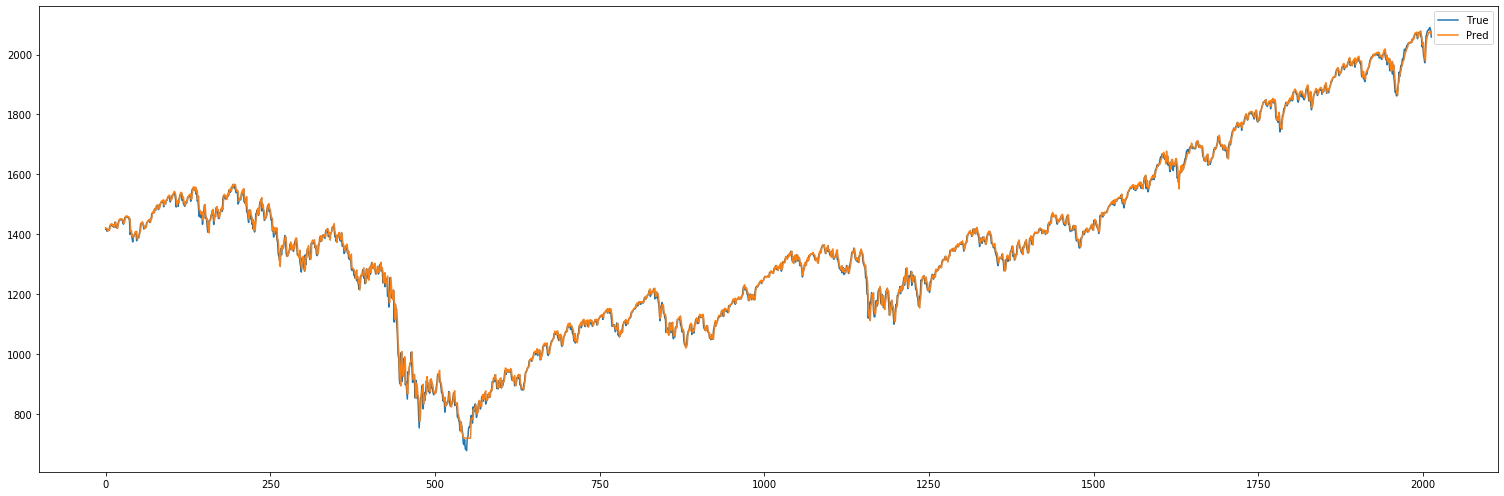

In [27]:
fig, ax = plt.subplots(1,1,figsize = (21,7))
ax.plot(data_dict['result'][preprocess_idx].Train_y[:,-1,:], label = 'True')
ax.plot(train_pred[:,-1,:], label = 'Pred')
ax.legend()
fig.tight_layout()

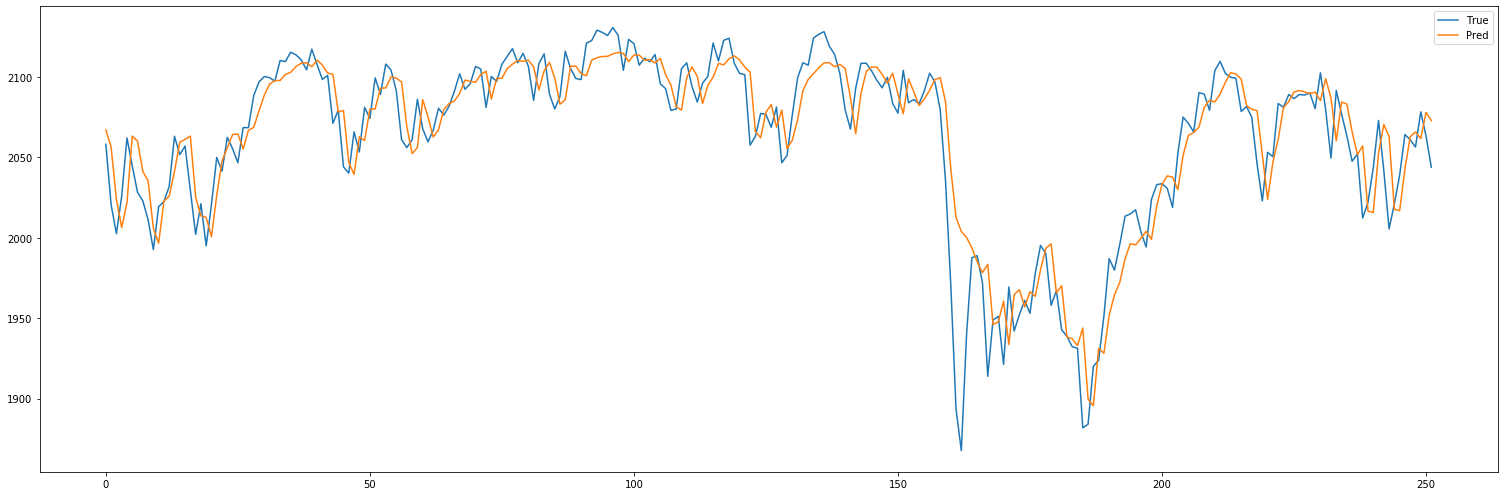

In [28]:
fig, ax = plt.subplots(1,1,figsize = (21,7))
ax.plot(data_dict['result'][preprocess_idx].Valid_y[:,-1,:], label = 'True')
ax.plot(valid_pred[:,-1,:], label = 'Pred')
ax.legend()
fig.tight_layout()

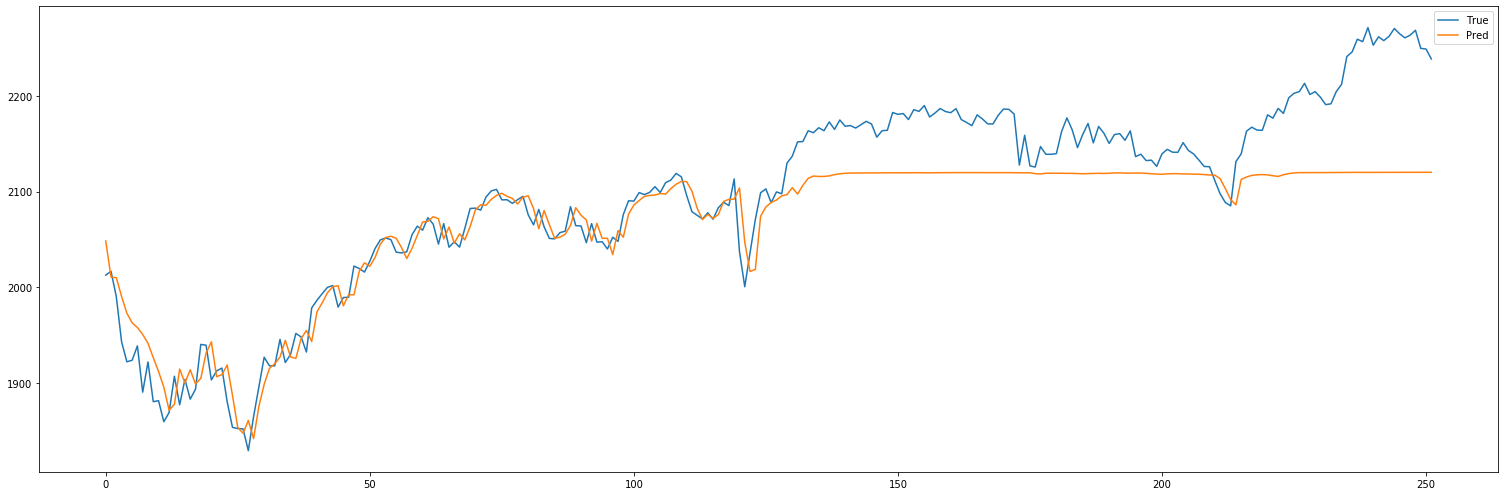

In [29]:
fig, ax = plt.subplots(1,1,figsize = (21,7))
ax.plot(data_dict['result'][preprocess_idx].Test_y[:,-1,:], label = 'True')
ax.plot(test_pred[:,-1,:], label = 'Pred')
ax.legend()
fig.tight_layout()